# Filtering is necessary

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import corc.utils
import corc.graph_metrics.neb
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib

In [3]:
# dataset_name = "varied"
# dataset_name = "clusterlab10"
# dataset_name = "aniso"
dataset_name = "blobs"

X,y,_ = corc.utils.load_dataset(dataset_name, cache_path="../../cache")

In [54]:
tmm_model = corc.graph_metrics.neb.NEB(
    data=X,
    labels=y,
    n_components=30,
    optimization_iterations=10,
    min_cluster_size=0,
    tmm_regularization=1e-8,
    max_elongation=np.inf
)
tmm_model.fit(X, knn=20)

[[    9    35]
 [   53     2]
 [   45     1]
 [   19    38]
 [   35     5]
 [   26     7]
 [    3 30173]
 [   50     3]
 [    3  1929]
 [    4   331]
 [   44     7]
 [   77     5]
 [   64     4]
 [   39    21]
 [    4 19542]
 [   38     2]
 [   22     1]
 [   27     4]
 [   17    21]
 [   36     4]
 [   75     3]
 [   24   174]
 [    4  2676]
 [   30     4]
 [   16     4]
 [   63     3]
 [   36     1]
 [   51    10]
 [   66    11]
 [   20   158]]
After filtering 30 components, we are left with 30 components


tmm: 100%|██████████| 600/600 [00:41<00:00, 14.41it/s]


In [22]:
mixture_model = copy.deepcopy(tmm_model.mixture_model)
pure_mixture_model = copy.deepcopy(tmm_model.mixture_model)
problematic_mixture_model = copy.deepcopy(tmm_model.mixture_model)


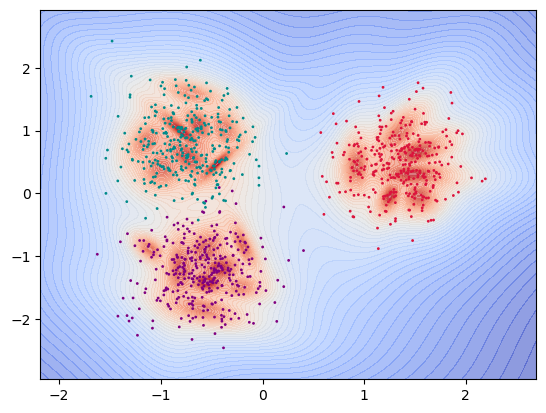

In [37]:

def plot_field(
    data_X,
    data_y,
    mixture_model,
    levels=20,
    paths=None,  # storage of all paths
    selection=None,  # selection which paths to plot
    save_path=None,
    axis=None,
    plot_points=True,  # whether data_X is plotted
    transformed_points=None,
    grid_resolution=128,
):
    """Plots the TMM/GMM field and the optimized paths (if available).
    selection: selects which paths are included in the plot, by default, all paths are included.
      other typical options: MST through selection=zip(mst.row,mst.col) and individuals via e.g. [(0,1), (3,4)]

    """
    if axis is None:
        figure, axis = plt.subplots(1, 1)

    # Compute TSNE if necessary
    if data_X.shape[-1] > 2:
        if transformed_points is None:
            transformed_points = corc.utils.get_TSNE_embedding(data_X)
        locations = corc.utils.snap_points_to_TSNE(
            locations, data_X, transformed_points
        )
    else:
        transformed_points = data_X

    # plot the energy landscape if possible
    if data_X.shape[-1] == 2:
        # grid coordinates
        margin = 0.5
        x = np.linspace(
            data_X[:, 0].min() - margin, data_X[:, 0].max() + margin, grid_resolution
        )
        y = np.linspace(
            data_X[:, 1].min() - margin, data_X[:, 1].max() + margin, grid_resolution
        )
        XY = np.stack(np.meshgrid(x, y), -1)

        # get scores for the grid values
        mm_probs = mixture_model.score_samples(XY.reshape(-1, 2)).reshape(
            grid_resolution, grid_resolution
        )
        # plotting the energy landscape
        axis.contourf(
            x,
            y,
            np.clip(mm_probs, None, 0),
            levels=levels,
            cmap="coolwarm",
            alpha=0.6,
            zorder=-10,
        )

    # plot the raw data
    if plot_points:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkcyan", "purple", "crimson"])
        axis.scatter(
            transformed_points[:, 0], 
            transformed_points[:, 1], 
            s=1, 
            label="raw data",
            c=data_y,
            cmap=cmap
        )
fig, ax = plt.subplots()
plot_field(X,y,mixture_model,levels=60, grid_resolution=1024,axis=ax)
# plt.savefig("../../figures/filtering1.pdf")
# plt.savefig("../../figures/filtering1.png")
plt.show()


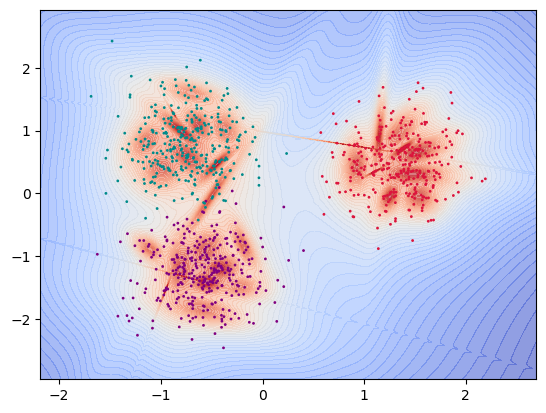

In [38]:
plot_field(X,y,tmm_model.mixture_model,levels=60, grid_resolution=1024)

In [12]:
def filter_mixture(mixture_model, data_X, min_cluster_size=10, max_elongation=1000):
        # compute elongations and cluster sizes
        counts = mixture_model.get_counts(data_X)
        elongations = mixture_model.get_elongations()

        # construct filter (True will be kept)
        component_filter = np.logical_and(
            counts > min_cluster_size, np.array(elongations) > max_elongation
        )

        # filter the components
        mixture_model.centers = mixture_model.centers[component_filter]
        mixture_model.covs = mixture_model.covs[component_filter]
        mixture_model.weights = mixture_model.weights[component_filter]

In [26]:
filter_mixture(problematic_mixture_model,X,min_cluster_size=0, max_elongation=160)

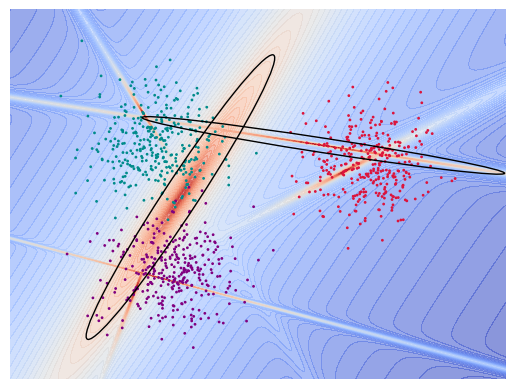

In [45]:
index =4
eigenvalues, eigenvectors = np.linalg.eig(problematic_mixture_model.covs[index])
width = 15* np.sqrt(eigenvalues[0])
height = 15 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse = matplotlib.patches.Ellipse(problematic_mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")

index =3
eigenvalues, eigenvectors = np.linalg.eig(problematic_mixture_model.covs[index])
width = 58* np.sqrt(eigenvalues[0])
height = 500 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse2 = matplotlib.patches.Ellipse(problematic_mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")



fig, ax = plt.subplots()
plot_field(X,y,problematic_mixture_model,levels=60, grid_resolution=1024,axis=ax)
ax.add_patch(ellipse)
ax.add_patch(ellipse2)
plt.axis('off')
plt.savefig("../../figures/filtering2.pdf",bbox_inches="tight")
plt.savefig("../../figures/filtering2.png",bbox_inches="tight", dpi=300)
plt.show()

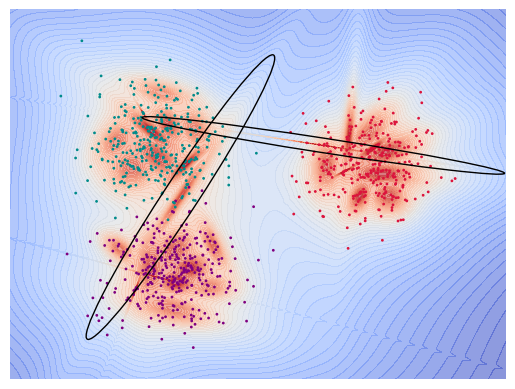

In [46]:
# Calculate the eigenvalues and eigenvectors of the covariance matrix
index =4
eigenvalues, eigenvectors = np.linalg.eig(problematic_mixture_model.covs[index])
width = 15* np.sqrt(eigenvalues[0])
height = 15 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse = matplotlib.patches.Ellipse(problematic_mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")

index =3
eigenvalues, eigenvectors = np.linalg.eig(problematic_mixture_model.covs[index])
width = 58* np.sqrt(eigenvalues[0])
height = 500 * np.sqrt(eigenvalues[1])
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi
ellipse2 = matplotlib.patches.Ellipse(problematic_mixture_model.centers[index], width, height, angle=angle, fill=False,color="black")


fig, ax = plt.subplots()
plot_field(X,y,pure_mixture_model,levels=60, grid_resolution=1024,axis=ax)
ax.add_patch(ellipse)
ax.add_patch(ellipse2)
plt.axis('off')
plt.savefig("../../figures/filtering1.pdf",bbox_inches="tight")
plt.savefig("../../figures/filtering1.png",bbox_inches="tight", dpi=300)
plt.show()

In [32]:
mixture_model.filter_components(X,min_cluster_size=10, max_elongation=100)

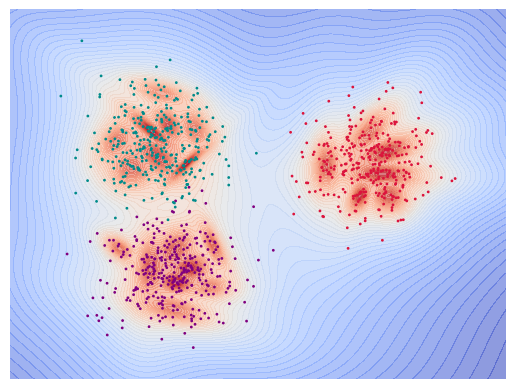

In [47]:
fig, ax = plt.subplots()
plot_field(X,y,mixture_model,levels=60, grid_resolution=1024,axis=ax)
plt.axis('off')
plt.savefig("../../figures/filtering3.pdf",bbox_inches="tight")
plt.savefig("../../figures/filtering3.png",bbox_inches="tight", dpi=300)
plt.show()

[[53  2]
 [45  1]
 [19 38]
 [35  5]
 [26  7]
 [54  3]
 [62  7]
 [93  5]
 [65  4]
 [42 21]
 [38  2]
 [22  1]
 [27  4]
 [17 21]
 [37  4]
 [81  3]
 [30  4]
 [16  4]
 [72  3]
 [37  1]
 [55 10]
 [74 11]]
After filtering 30 components, we are left with 22 components
[[53  2]
 [45  1]
 [19 38]
 [35  5]
 [26  7]
 [54  3]
 [62  7]
 [93  5]
 [65  4]
 [42 21]
 [38  2]
 [22  1]
 [27  4]
 [17 21]
 [37  4]
 [81  3]
 [30  4]
 [16  4]
 [72  3]
 [37  1]
 [55 10]
 [74 11]]


tmm: 100%|██████████| 440/440 [00:25<00:00, 17.32it/s]


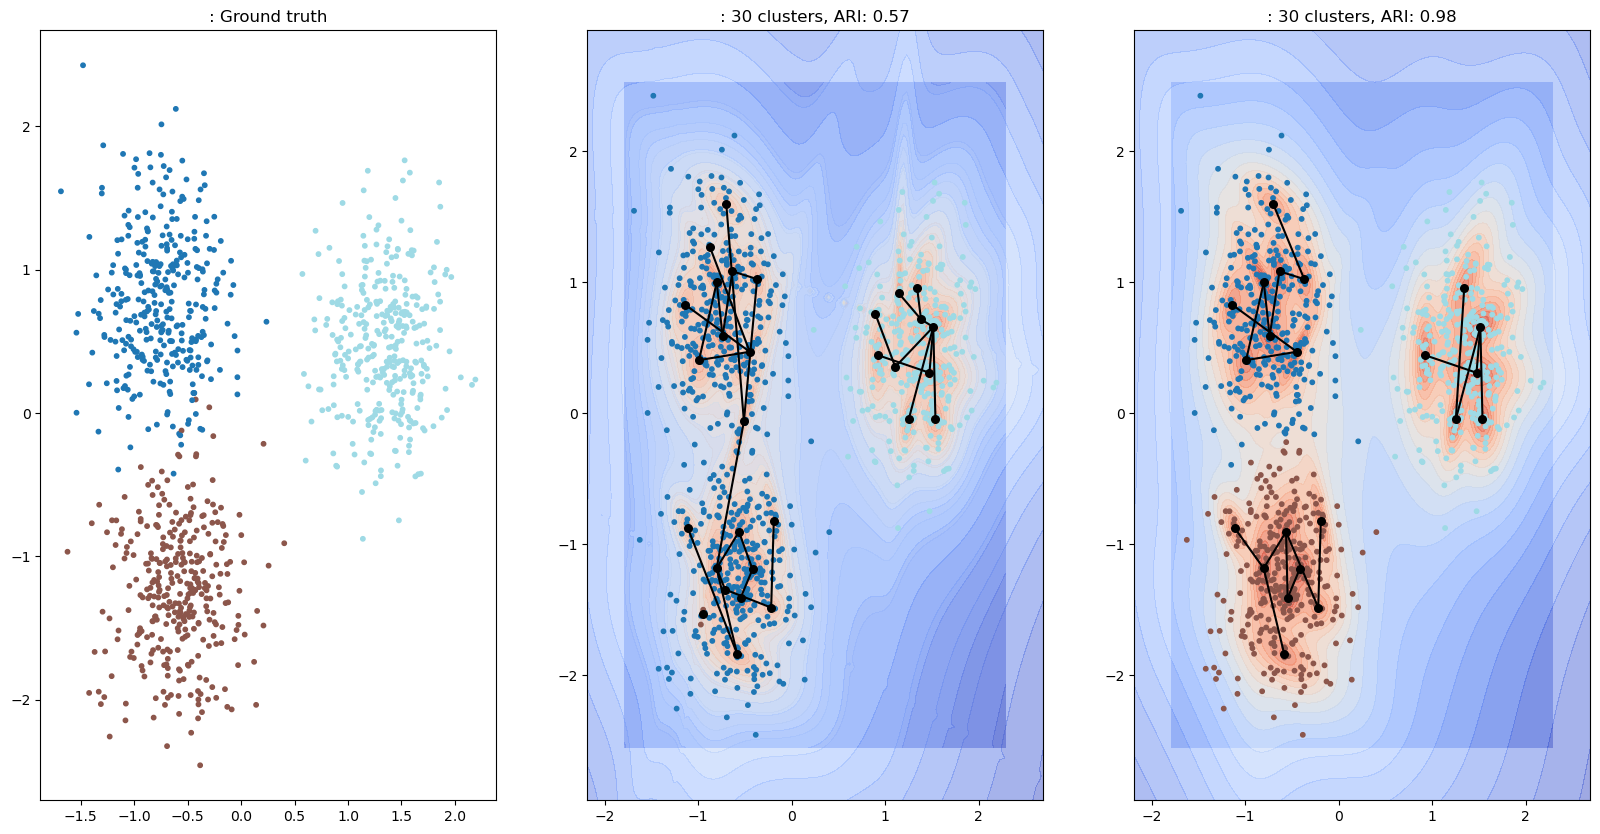

In [53]:
import corc.tmm_plots

filtered_tmm_model = corc.graph_metrics.neb.NEB(
    data=X,
    labels=y,
    n_components=30,
    optimization_iterations=10,
    min_cluster_size=10,
    tmm_regularization=1e-8,
    max_elongation=100
)
filtered_tmm_model.fit(X, knn=20)
# filtered_tmm_model.mixture_model.filter_components(X,min_cluster_size=10, max_elongation=100)
plot = corc.tmm_plots.plot_tmm_models([tmm_model,filtered_tmm_model],X,y,"")